## Classification

In this example, we will classify patient as being dead or not, given a Covid-19 patient's current symptom, status, and medical history. Logistic regression, linear discriminant analysis and quadratic discriminant analysis will be used.

The dataset contains 1048576 rows and 21 unique features:


sex: 1 for female and 2 for male.

age: of the patient.

classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.

patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.

pneumonia: whether the patient already have air sacs inflammation or not.

pregnancy: whether the patient is pregnant or not.

diabetes: whether the patient has diabetes or not.

copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.

asthma: whether the patient has asthma or not.

inmsupr: whether the patient is immunosuppressed or not.

hypertension: whether the patient has hypertension or not.

cardiovascular: whether the patient has heart or blood vessels related disease.

renal chronic: whether the patient has chronic renal disease or not.

other disease: whether the patient has other disease or not.

obesity: whether the patient is obese or not.

tobacco: whether the patient is a tobacco user.

usmr: Indicates whether the patient treated medical units of the first, second or third level.

medical unit: type of institution of the National Health System that provided the care.

intubed: whether the patient was connected to the ventilator.

icu: Indicates whether the patient had been admitted to an Intensive Care Unit.

date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

In [1]:
import pandas as pd  # For DataFrames and Series
import numpy as np  # For arrays and matrices
import matplotlib.pyplot as plt # Creating static, animated, and interactive visualizations
import seaborn as sns  # Statistical data visualization library, for a high-level interface for drawing attractive and informative statistical graphics.


from sklearn.preprocessing import LabelEncoder  # LabelEncoder is used for encoding categorical variables as integers.

from sklearn.model_selection import train_test_split, cross_val_score 
# train_test_split splits a dataset into training and testing sets. 
# cross_val_score is used to perform cross-validation

from sklearn.metrics import roc_curve, auc, confusion_matrix
# roc_curve generate Receiver Operating Characteristic (ROC) curves for binary classification problems.
# auc computes the Area Under the Curve (AUC) from the ROC curve.
# confusion_matrix is used to compute a confusion matrix to evaluate the performance of a classification model.

%matplotlib inline  
# Jupyter Notebook or IPython magic command
# Ensures that Matplotlib plots will be displayed directly in the notebook cells, rather than in separate windows.

In [2]:
data = pd.read_csv('Covid Data.csv')
data.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [3]:
# Create a new column 'DEAD',Convert 'DATE_DIED' to 'Y' and 'N'  
data['DEAD'] = data['DATE_DIED'].apply(lambda x: 'N' if x == '9999-99-99' else 'Y')
data = data.drop(columns=['DATE_DIED'])
data.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DEAD
0,2,1,1,1,97,1,65,2,2,2,...,2,1,2,2,2,2,2,3,97,Y
1,2,1,2,1,97,1,72,97,2,2,...,2,1,2,2,1,1,2,5,97,Y
2,2,1,2,2,1,2,55,97,1,2,...,2,2,2,2,2,2,2,3,2,Y
3,2,1,1,1,97,2,53,2,2,2,...,2,2,2,2,2,2,2,7,97,Y
4,2,1,2,1,97,2,68,97,1,2,...,2,1,2,2,2,2,2,3,97,Y


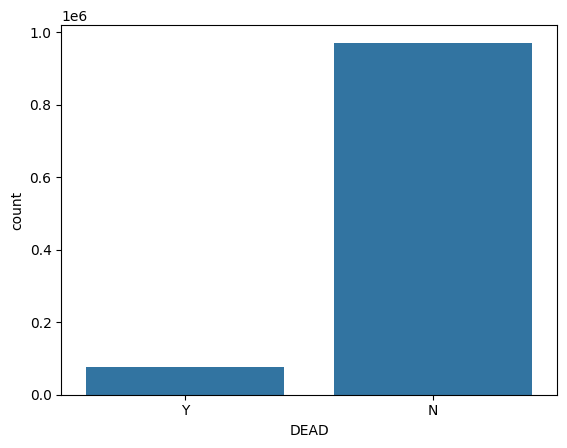

In [4]:
# Plot the bar chart
ax = sns.countplot(x = data['DEAD'], data=data)

In [8]:
# Creates count plots for each column in a DataFrame, allowing differentiation based on a hue (colour) variable.
def plot_data(hue, data): 
    for i, col in enumerate(data.columns):
        plt.figure(i)
        ax = sns.countplot(x=data[col], hue=hue, data=data)
        
# enumerate is a built-in Python function that allows you to loop over an iterable (like a list, tuple, or string) and get both the index and the value of each element in the iterable. It returns a tuple with two elements: the index (starting from 0) and the corresponding element.

# Preprocessing

In [5]:
# Find number of missing values
for col in data.columns:
    missing_values = data[col].isin([97, 99]).sum()
    print(f"{col}: {missing_values}")

USMER: 0
MEDICAL_UNIT: 0
SEX: 0
PATIENT_TYPE: 0
INTUBED: 855869
PNEUMONIA: 16003
AGE: 221
PREGNANT: 523511
DIABETES: 0
COPD: 0
ASTHMA: 0
INMSUPR: 0
HIPERTENSION: 0
OTHER_DISEASE: 0
CARDIOVASCULAR: 0
OBESITY: 0
RENAL_CHRONIC: 0
TOBACCO: 0
CLASIFFICATION_FINAL: 0
ICU: 856032
DEAD: 0


In [7]:
columns_to_replace = ['USMER', 'SEX', 'PATIENT_TYPE', 'DIABETES', 'ASTHMA', 
                      'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'COPD',
                      'CARDIOVASCULAR', 'OBESITY',  'RENAL_CHRONIC', 'TOBACCO']

data[columns_to_replace] = data[columns_to_replace].replace(2, 0)

In [8]:
#Dropping columns
columns_to_drop =['INTUBED','PNEUMONIA','PREGNANT','ICU']
data.drop(columns = columns_to_drop, inplace=True)
# inplace=True determines whether the operation should modify the DataFrame in place 
# or return a new DataFrame with the specified columns dropped.
data.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,DEAD
0,0,1,1,1,65,0,0,0,0,1,0,0,0,0,0,3,Y
1,0,1,0,1,72,0,0,0,0,1,0,0,1,1,0,5,Y
2,0,1,0,0,55,1,0,0,0,0,0,0,0,0,0,3,Y
3,0,1,1,1,53,0,0,0,0,0,0,0,0,0,0,7,Y
4,0,1,0,1,68,1,0,0,0,1,0,0,0,0,0,3,Y


In [9]:
# Dropping age-missing rows
condition = (data['AGE'] != 97) & (data['AGE'] != 99)
data = data[condition]

In [10]:
# Find the largest age
largest_value = data['AGE'].max()
largest_value

121

In [12]:
# Turn ages to age groups
bin_edges = [0, 18, 30, 40, 50, 60, 70, 80, 90, 121]
bin_labels = ['0-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89','90-121']
# Bin labels must be one fewer than the number of bin edges

# Use cut to create age groups
# data['AGE_GROUPE'] = pd.cut(data['AGE'], bins=bin_edges, labels=bin_labels, right=False)  #panda found this ambiguous


# loc for indexing and assignment
data.loc[:, 'AGE_GROUPE'] = pd.cut(data['AGE'], bins=bin_edges, labels=bin_labels, right=False)
# (:) indicates that we want to include all rows. and the column 'AGE_GROUPE'. Equivalent to data['AGE_GROUPE'].
#calculates the age groups and returns a Series.

print(data[['AGE', 'AGE_GROUPE']].head())

   AGE AGE_GROUPE
0   65      60-69
1   72      70-79
2   55      50-59
3   53      50-59
4   68      60-69


In [13]:
# Dropping the age, leaving only age groups
data = data.drop(columns=['AGE'])
data

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,DEAD,AGE_GROUPE
0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,3,Y,60-69
1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,5,Y,70-79
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,3,Y,50-59
3,0,1,1,1,0,0,0,0,0,0,0,0,0,0,7,Y,50-59
4,0,1,0,1,1,0,0,0,1,0,0,0,0,0,3,Y,60-69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,0,13,0,1,0,0,0,0,0,0,0,0,0,0,7,N,40-49
1048571,1,13,0,0,0,0,0,0,1,0,0,0,0,0,7,N,50-59
1048572,0,13,0,1,0,0,0,0,0,0,0,0,0,0,7,N,50-59
1048573,0,13,0,1,0,0,0,0,0,0,0,0,0,0,7,N,18-29


In [14]:
le = LabelEncoder()

data['DEAD'] = le.fit_transform(data['DEAD']) # encoder on the unique values in the 'DEAD' column and then transforms those values into numerical labels

data.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,DEAD,AGE_GROUPE
0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,3,1,60-69
1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,5,1,70-79
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,3,1,50-59
3,0,1,1,1,0,0,0,0,0,0,0,0,0,0,7,1,50-59
4,0,1,0,1,1,0,0,0,1,0,0,0,0,0,3,1,60-69


In [15]:
# Perform one-hot encoding 
encoded_data = pd.get_dummies(data)  #  Converts categorical variables into binary (0 or 1) indicators for each category
encoded_data.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,...,DEAD,AGE_GROUPE_0-17,AGE_GROUPE_18-29,AGE_GROUPE_30-39,AGE_GROUPE_40-49,AGE_GROUPE_50-59,AGE_GROUPE_60-69,AGE_GROUPE_70-79,AGE_GROUPE_80-89,AGE_GROUPE_90-121
0,0,1,1,1,0,0,0,0,1,0,...,1,False,False,False,False,False,True,False,False,False
1,0,1,0,1,0,0,0,0,1,0,...,1,False,False,False,False,False,False,True,False,False
2,0,1,0,0,1,0,0,0,0,0,...,1,False,False,False,False,True,False,False,False,False
3,0,1,1,1,0,0,0,0,0,0,...,1,False,False,False,False,True,False,False,False,False
4,0,1,0,1,1,0,0,0,1,0,...,1,False,False,False,False,False,True,False,False,False


# Model

In [ ]:
y = data['DEAD'].values.reshape(-1, 1)
X = data.drop(['DEAD'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)

# Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression